[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vanguardfox/ads509-group5/blob/main/ADS509_Final_Project.ipynb)

# Evaluating Financial Independence / Retire Early (FIRE) Thresholds by Demographic

What is the Financial Independence number the FIRE community is aiming for by age, location, and over time?

# Group 5 Objective:
 The purpose of this project is to evaluate the FIRE financial thresholds by demographic groups such as age and location as well as changes in trends over times. Resulting analysis can be used in a variety of applications including leading economic sentiment predictions, generational assessment of financial health, and others via a Flask implementation.

# Reddit Scrape

Community: r/FIRE \
thread: /What_is_your_fire_number/ \
Code Reference: with help from ChatGPT https://chatgpt.com/ and https://colab.research.google.com/


**Privacy note:**

*   Credentials were created for the class but might have to figure out how to hide
*   Username will also have to be masked to be anonymous

In [115]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

(Optional: Install packages as needed)

In [ ]:
#!pip install requests beautifulsoup4
#!pip install pyngrok

Import Libraries

In [183]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import csv
import requests
import time
import datetime
import nltk
import random
import pickle
import threading
import socket
import io
import base64
import plotly.graph_objs as go


from typing import Optional, Tuple
from pyngrok import ngrok
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import pairwise
from bs4 import BeautifulSoup
from requests.auth import HTTPBasicAuth
from os import read
from flask import Flask, render_template, request, jsonify
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

## Initialize API Credentials

In [117]:
# Reddit API credentials
client_id = '8-xAlbBmc1_FYraSwJENtw'
client_secret = 'Jg9JyK9R_ixyNESMaGE3BwLzmBhf2w'
username = 'Western_Signal4499'
password = 'ADS509finAl'
user_agent = 'ADS509Scrapper/0.1 by Western_Signal4499'

# Get the OAuth token
auth = HTTPBasicAuth(client_id, client_secret)
headers = {'User-Agent': user_agent}
data = {'grant_type': 'password', 'username': username, 'password': password}

response = requests.post('https://www.reddit.com/api/v1/access_token', auth=auth, headers=headers, data=data)

if response.status_code == 200:
    token = response.json()['access_token']
else:
    print(f"Error: {response.status_code}, {response.text}")

## Use access_token field from JSON to query threads

In [118]:
# Use the token to search for threads
headers['Authorization'] = f'bearer {token}'

# Constructs a string for the r/FIRE URL to query "what is your fire number"
# restrict_sr=1 ensures that the query is constrained to only this subreddit
search_url = "https://oauth.reddit.com/r/FIRE/search?q=what%20is%20your%20fire%20number&restrict_sr=1"

# Store results of GET requrest to the API for the given "search_url"
search_response = requests.get(search_url, headers=headers)

# If the API GET is successful...
if search_response.status_code == 200: # Code 200 means the request was flagged as successful
    search_data = search_response.json() # Parse the JSON data from the response
    #print(search_data)
    threads = search_data['data']['children'] # Extract the list of threads

    # Initialize a CSV and writes an head with columns (within .writerow() arg)
    with open('fire_comments.csv', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Thread ID', 'Title', 'User', 'Comment', 'Post Time', 'Comment Time'])

        # Iterate through each thread from API's response JSON
        for thread in threads:
            thread_title = thread['data']['title'] # Parse and extract title
            thread_id = thread['data']['id'] # Parse and extract id
            thread_time = thread['data']['created_utc']  # Extract post time (in Unix time)
            # Convert the post time to a parsible date format
            thread_time_norm = datetime.datetime.utcfromtimestamp(thread_time).strftime('%Y-%m-%d %H:%M:%S')

            # Prepare URL as a string for better code handling
            comments_url = f"https://oauth.reddit.com/r/FIRE/comments/{thread_id}.json"

            # Store results of GET to fetch comments of the current iterated thread
            comments_response = requests.get(comments_url, headers=headers)
            if comments_response.status_code == 200: # Again, check if GET is successful
                comments_data = comments_response.json() # Store JSON
                comments = comments_data[1]['data']['children'] # Parse and extract comments

                # Iterate through each comment
                for comment in comments:
                    if comment['kind'] == 't1': # Only iterate on top comments
                        username = comment['data']['author'] # Extract username
                        body = comment['data']['body'] # Extract text body

                        # Extract comment time, convert
                        comment_time = comment['data']['created_utc']
                        comment_time_norm = datetime.datetime.utcfromtimestamp(comment_time).strftime('%Y-%m-%d %H:%M:%S')

                        # Write parsed data into respective CSV row, mapped to column
                        writer.writerow([thread_id,
                                         thread_title,
                                         username,
                                         body,
                                         thread_time_norm,
                                         comment_time_norm])

                print(f"Thread ID: {thread_id}, Title: {thread_title}, User1: {username}, Comment: {body}, Post Time: {thread_time_norm}, Comment Time: {comment_time_norm}")
                sleep_time = random.uniform(1,3) # Rate Limiter
                time.sleep(sleep_time)

            else:
                print(f"Failed to retrieve comments for thread ID {thread_id} with status code {comments_response.status_code}")

else:
    print(f"Failed to retrieve search results with status code {search_response.status_code}")

Thread ID: 1fqzb0p, Title: What is your fire number? , User1: muy_carona, Comment: $8,675,309, Post Time: 2024-09-27 22:00:15, Comment Time: 2024-09-27 23:21:33
Thread ID: rfxxkz, Title: What is your fire number?, User1: xmxprztm, Comment: 4M at least. Going to move to Spain, Post Time: 2021-12-14 03:24:03, Comment Time: 2021-12-14 16:43:40
Thread ID: zddhma, Title: For folks who plan to FIRE in HCOL / VHCOL areas, what is your FIRE number? Why not move to MCOL / LCOL area?, User1: [deleted], Comment: Some services or experiences are only available in hcol areas. Good fine dining options and/or weather and or ___., Post Time: 2022-12-05 17:36:13, Comment Time: 2022-12-27 18:53:13
Thread ID: 10ex17r, Title: What is your FIRE number?, User1: zenjdg, Comment: My ideal scenario is $100k per month in tax-free cash flow., Post Time: 2023-01-18 03:44:27, Comment Time: 2023-11-04 15:20:39
Thread ID: z5a29v, Title: What is your fire number and how did you arrive at it?, User1: [deleted], Commen

## Verify the contents of the CSV that was created above and store as DataFrame

In [119]:
rfire_df = pd.read_csv('fire_comments.csv')
rfire_df.head()

,Thread ID,Title,User,Comment,Post Time,Comment Time
0,1fqzb0p,What is your fire number?,manimopo,1.5m with paid off houses,2024-09-27 22:00:15,2024-09-27 22:14:27
1,1fqzb0p,What is your fire number?,Animag771,I'm just waiting for someone to say something ...,2024-09-27 22:00:15,2024-09-27 22:43:43
2,1fqzb0p,What is your fire number?,wowsocool4u,$1.9m. Targeting a few months after i turn 50...,2024-09-27 22:00:15,2024-09-27 22:24:04
3,1fqzb0p,What is your fire number?,Aromatic_Heart,"On days I hate my job, 600k. The other days, d...",2024-09-27 22:00:15,2024-09-28 03:15:50
4,1fqzb0p,What is your fire number?,Ziqach,$2M with a paid off house. So stressful to see...,2024-09-27 22:00:15,2024-09-27 22:59:17


# Data Preprocessing

## Preliminary dataframe

In [120]:
rfire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Thread ID     1463 non-null   object
 1   Title         1463 non-null   object
 2   User          1463 non-null   object
 3   Comment       1463 non-null   object
 4   Post Time     1463 non-null   object
 5   Comment Time  1463 non-null   object
dtypes: object(6)
memory usage: 68.7+ KB


In [121]:
rfire_df['Title'].unique()

array(['What is your fire number? ', 'What is your fire number?',
       'For folks who plan to FIRE in HCOL / VHCOL areas, what is your FIRE number? Why not move to MCOL / LCOL area?',
       'What is your FIRE number?',
       'What is your fire number and how did you arrive at it?',
       "How to split finances when one is FIRE'd and one isn't FIRE'ing",
       'What is your FIRE number and at what age do you want to achieve it by?',
       'We’re all privileged',
       'How my wife and I will retire before 50; neither of us make over $75K',
       'Is toxic corporate culture why most of us want to Fire? ',
       '10 tips from my 20 year journey to financial freedom',
       'The cliff is steep: How do you choose to retire early when working 5 more years can bring so much more',
       'How did you come up with your FIRE number? What is the best calculator, way to get at it?',
       'Forgive me if this is too personal, but what was your estimated net worth around 18 and how did 

In [122]:
# Mask user names with a unique identifier
rfire_df['User'] = ['User ' + str(i + 1) for i in range(len(rfire_df))]

## Clean Dataset

In [123]:
# Retrive titles that contain the words "what is your fire number"
fire_df = rfire_df[rfire_df['Title'].str.contains(r'what\s*is\s*your\s*fire\s*number', case=False, na=False)]

print(fire_df['Title'].unique())
print(fire_df.info())

['What is your fire number? ' 'What is your fire number?'
 'For folks who plan to FIRE in HCOL / VHCOL areas, what is your FIRE number? Why not move to MCOL / LCOL area?'
 'What is your FIRE number?'
 'What is your fire number and how did you arrive at it?'
 'What is your FIRE number and at what age do you want to achieve it by?'
 'Married couples with young kids, what is your FIRE number and how is your progress?']
<class 'pandas.core.frame.DataFrame'>
Index: 433 entries, 0 to 1229
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Thread ID     433 non-null    object
 1   Title         433 non-null    object
 2   User          433 non-null    object
 3   Comment       433 non-null    object
 4   Post Time     433 non-null    object
 5   Comment Time  433 non-null    object
dtypes: object(6)
memory usage: 23.7+ KB
None


### Fire Number Extraction

Regular Expression Description

re.sub(r'[^a-zA-Z0-9\s$€£¥.]', '', text)

replaces matching substrings with an empty '' (effectively removing it)

Breakdown: \
^a-zA-Z0-9 = NOT alphanumeric characters \
\s = whitespace \
$€£¥ = Currency symbols \
. = Period / Decimal \

Objective:  \
Regular Expression removes everything that isn't an alphanumeric character or symbol above AFTER we've already removed periods from the line

text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

Breakdown: \
(?<!\d) Only match if the character before the period is not a digit (\d) *only checking with ?*


In [124]:
# Define text cleaning and extraction
def clean_and_extract(text: str) -> str:
    """Cleans the input text by normalizing financial identifiers."""
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Keep alphanumeric characters, spaces, and currency symbols
    text = re.sub(r'[^a-zA-Z0-9\s$€£¥.,/]', '', text)

    # Normalize financial identifiers
    financial_patterns = [
        (r'(?<!\w)\$?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s*(m|mm|mil)(?=\s|/|$)', r'\1 million'),
        (r'(?<!\w)\$?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s*(b|bil)(?=\s|$)', r'\1 billion'),
        (r'(?<!\w)\$?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s*(k|thousand)(?=\s|$)', r'\1 thousand'),
    ]

    for pattern, replacement in financial_patterns:
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # Handle ranges and multiple values by replacing the slash with a space
    text = re.sub(
    r'(\d+(?:\.\d+)?)\s*/\s*(\d+(?:\.\d+)?)\s*(mil|m|k)',
    lambda match: f"{match.group(1)} {match.group(3)} {match.group(2)} {match.group(3)}",
    text,
    flags=re.IGNORECASE
    )

    # Convert to lowercase and remove extra spaces
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def extract_fire_numbers(text: str) -> float:
    """Extracts and converts financial identifiers to numeric values."""
    text = re.sub(r',', '', text)  # Remove commas

    fire_numbers = re.findall(r'(\$?\d+(?:\.\d+)?)\s*(million|billion|thousand|m|b|k)?', text, re.IGNORECASE)

    total = 0.0
    for num, unit in fire_numbers:
        num_value = float(num.replace('$', ''))

        if unit and unit.lower() in ['million', 'm']:
            total = max(total, num_value * 1_000_000)
        elif unit and unit.lower() in ['billion', 'b']:
            total = max(total, num_value * 1_000_000_000)
        elif unit and unit.lower() in ['thousand', 'k']:
            total = max(total, num_value * 1_000)
        else:
            total = max(total, num_value)

    return total

In [125]:
# Cleaned Comments
fire_df['Cleaned Comment'] = fire_df['Comment'].apply(clean_and_extract)

# Extract FIRE numbers
fire_df['FIRE #'] = fire_df['Cleaned Comment'].apply(extract_fire_numbers)

# Filter out FIRE numbers less than 100,000
fire_df = fire_df[fire_df['FIRE #'] >= 100000]

# Convert FIRE # to numeric
fire_df['FIRE #'] = pd.to_numeric(fire_df['FIRE #'])

# Format the FIRE Number for better readability without commas
fire_df['FIRE Number'] = fire_df['FIRE #'].apply(lambda x: f"{x:.2f}")

# Convert FIRE Number back to numeric for calculations if needed
fire_df['FIRE Number'] = pd.to_numeric(fire_df['FIRE Number'])

# Drop the original FIRE # column
fire_df.drop(columns=['FIRE #'], inplace=True)

In [126]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337 entries, 0 to 1228
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Thread ID        337 non-null    object 
 1   Title            337 non-null    object 
 2   User             337 non-null    object 
 3   Comment          337 non-null    object 
 4   Post Time        337 non-null    object 
 5   Comment Time     337 non-null    object 
 6   Cleaned Comment  337 non-null    object 
 7   FIRE Number      337 non-null    float64
dtypes: float64(1), object(7)
memory usage: 23.7+ KB


In [127]:
# Check random samples to improve fire number extraction
random_sample = fire_df.sample(n=10, random_state=62)
random_sample[['Comment', 'Cleaned Comment', 'FIRE Number']]

,Comment,Cleaned Comment,FIRE Number
358,"$2,000,000 gives us $80,000/year. That’s what ...","$2,000,000 gives us $80,000/year. thats what i...","2,000,000.00"
270,650k for two of us. Though I'm considering pic...,650 thousand for two of us. though im consider...,"650,000.00"
177,$3M. Put it in indexes where avg return is 7% ...,$3m. put it in indexes where avg return is 7 a...,"3,000,000.00"
244,I think NYC has higher density of opportunitie...,i think nyc has higher density of opportunitie...,"2,000,000.00"
87,"About 4.2 - 140-160k annual spend, not includi...","about 4.2 140160k annual spend, not including ...","140,160,000.00"
73,I've looked into my numbers and I think at 60 ...,ive looked into my numbers and i think at 60 i...,"8,000,000,000.00"
337,"$10 million. \n\nProbably not attainable, but ...","$10 million. probably not attainable, but that...","10,000,000.00"
319,$2.5M. Assuming no investment growth at all (...,$2.5m. assuming no investment growth at all an...,"2,500,000.00"
1227,"No kids, 100Mil","no kids, 100 million","100,000,000.00"
246,I’m from a LCOL area that offered nothing I wa...,im from a lcol area that offered nothing i was...,"5,000,000.00"


### Year Extraction

In [128]:
fire_df['Post Year'] = pd.to_datetime(fire_df['Post Time']).dt.year
fire_df['Comment Year'] = pd.to_datetime(fire_df['Comment Time']).dt.year

In [129]:
# Display the first few rows of the DataFrame
#print("FIRE Dataframe\n")
fire_df.head()
#print()

# Print general information about the DataFrame with a proper newline
#print("FIRE DataFrame General Info\n")
#print(fire_df.info())

,Thread ID,Title,User,Comment,Post Time,Comment Time,Cleaned Comment,FIRE Number,Post Year,Comment Year
0,1fqzb0p,What is your fire number?,User 1,1.5m with paid off houses,2024-09-27 22:00:15,2024-09-27 22:14:27,1.5 million with paid off houses,"1,500,000.00",2024,2024
1,1fqzb0p,What is your fire number?,User 2,I'm just waiting for someone to say something ...,2024-09-27 22:00:15,2024-09-27 22:43:43,im just waiting for someone to say something l...,"1,000,000.00",2024,2024
2,1fqzb0p,What is your fire number?,User 3,$1.9m. Targeting a few months after i turn 50...,2024-09-27 22:00:15,2024-09-27 22:24:04,$1.9m. targeting a few months after i turn 50 ...,"1,900,000.00",2024,2024
3,1fqzb0p,What is your fire number?,User 4,"On days I hate my job, 600k. The other days, d...",2024-09-27 22:00:15,2024-09-28 03:15:50,"on days i hate my job, 600k. the other days, d...","3,000,000.00",2024,2024
4,1fqzb0p,What is your fire number?,User 5,$2M with a paid off house. So stressful to see...,2024-09-27 22:00:15,2024-09-27 22:59:17,2 million with a paid off house. so stressful ...,"2,000,000.00",2024,2024


### Graph number of posts by year

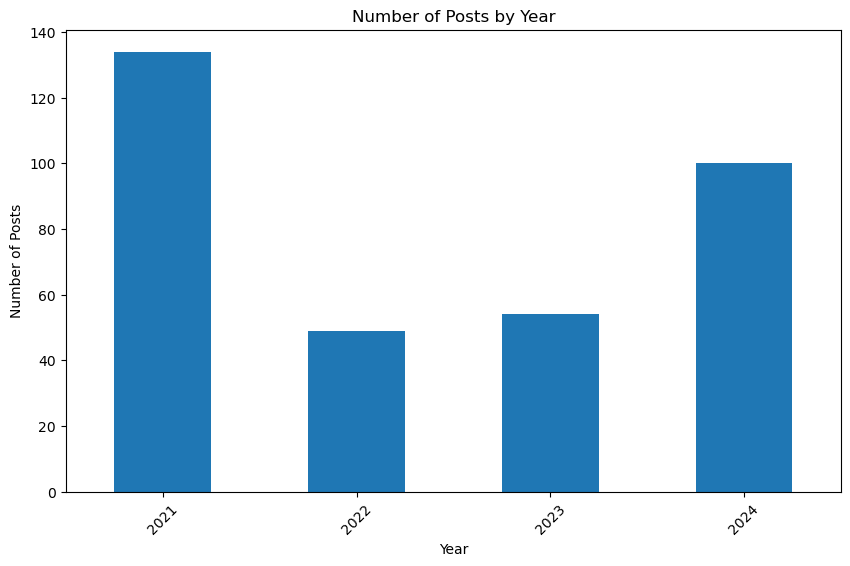

In [130]:
post_counts_by_year = fire_df.groupby('Post Year').size()
plt.figure(figsize=(10, 6))
post_counts_by_year.plot(kind='bar')
plt.title('Number of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

## Descriptive Stats

### Handle outliers (1.5*IQR +/- Q1|Q3 Method)

In [131]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

In [132]:
fire_df['Capped FIRE Number'] = cap_outliers(fire_df['FIRE Number'])

### Mean and Median FIRE number by Post Year

In [133]:
mean_fire_by_post_year = fire_df.groupby('Post Year')['Capped FIRE Number'].mean()
median_fire_by_post_year = fire_df.groupby('Post Year')['Capped FIRE Number'].median()
fire_stats_by_post_year = pd.DataFrame({
    'Mean FIRE': mean_fire_by_post_year,
    'Median FIRE': median_fire_by_post_year
})
pd.options.display.float_format = '{:,.2f}'.format
fire_stats_by_post_year

,Mean FIRE,Median FIRE
Post Year,,
2021,"4,099,614.43","2,925,000.00"
2022,"4,531,352.04","3,500,000.00"
2023,"4,174,685.19","2,500,000.00"
2024,"3,854,217.48","2,850,000.00"


### Mean and Median FIRE number by Comment Year

In [134]:
mean_fire_by_comment_year = fire_df.groupby('Comment Year')['Capped FIRE Number'].mean()
median_fire_by_comment_year = fire_df.groupby('Comment Year')['Capped FIRE Number'].median()
fire_stats_by_comment_year = pd.DataFrame({
    'Mean FIRE': mean_fire_by_comment_year,
    'Median FIRE': median_fire_by_comment_year
})
pd.options.display.float_format = '{:,.2f}'.format
fire_stats_by_comment_year

,Mean FIRE,Median FIRE
Comment Year,,
2021,"4,089,085.21","2,850,000.00"
2022,"4,531,352.04","3,500,000.00"
2023,"4,247,792.45","2,500,000.00"
2024,"3,835,507.33","2,850,000.00"


### Create CountVectorizer matrix for the cleaned comments

In [135]:
vectorizer_ct = CountVectorizer(stop_words='english')
X_ct = vectorizer_ct.fit_transform(fire_df['Cleaned Comment'])

### Create Term Frequency - Inverse Document Frequency scored vectors

In [136]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=1000) # Cap the size for memory
X_tfidf = vectorizer_tfidf.fit_transform(fire_df['Cleaned Comment'])

In [137]:
# Save the CountVectorizer to a file

with open('vectorizer_ct.pkl', 'wb') as f:
    pickle.dump(vectorizer_ct, f)

In [138]:
# Save the TfidfVectorizer to a file
with open('vectorizer_tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer_tfidf, f)

In [139]:
# Save the CountVectorizer to a file
with open('vectorizer_ct.pkl', 'rb') as f:
    vectorizer_ct = pickle.load(f)

with open('vectorizer_tfidf.pkl', 'rb') as f:
    vectorizer_tfidf = pickle.load(f)


## Exploratory Data Analysis

In [140]:
# Create a copy of fire_df with specific columns
fire_df_copy = fire_df[['Thread ID', 'Title', 'User', 'Post Time', 'Comment Time', 'FIRE Number']].copy()

# Copy DataFrame
fire_df_copy.head()

,Thread ID,Title,User,Post Time,Comment Time,FIRE Number
0,1fqzb0p,What is your fire number?,User 1,2024-09-27 22:00:15,2024-09-27 22:14:27,"1,500,000.00"
1,1fqzb0p,What is your fire number?,User 2,2024-09-27 22:00:15,2024-09-27 22:43:43,"1,000,000.00"
2,1fqzb0p,What is your fire number?,User 3,2024-09-27 22:00:15,2024-09-27 22:24:04,"1,900,000.00"
3,1fqzb0p,What is your fire number?,User 4,2024-09-27 22:00:15,2024-09-28 03:15:50,"3,000,000.00"
4,1fqzb0p,What is your fire number?,User 5,2024-09-27 22:00:15,2024-09-27 22:59:17,"2,000,000.00"


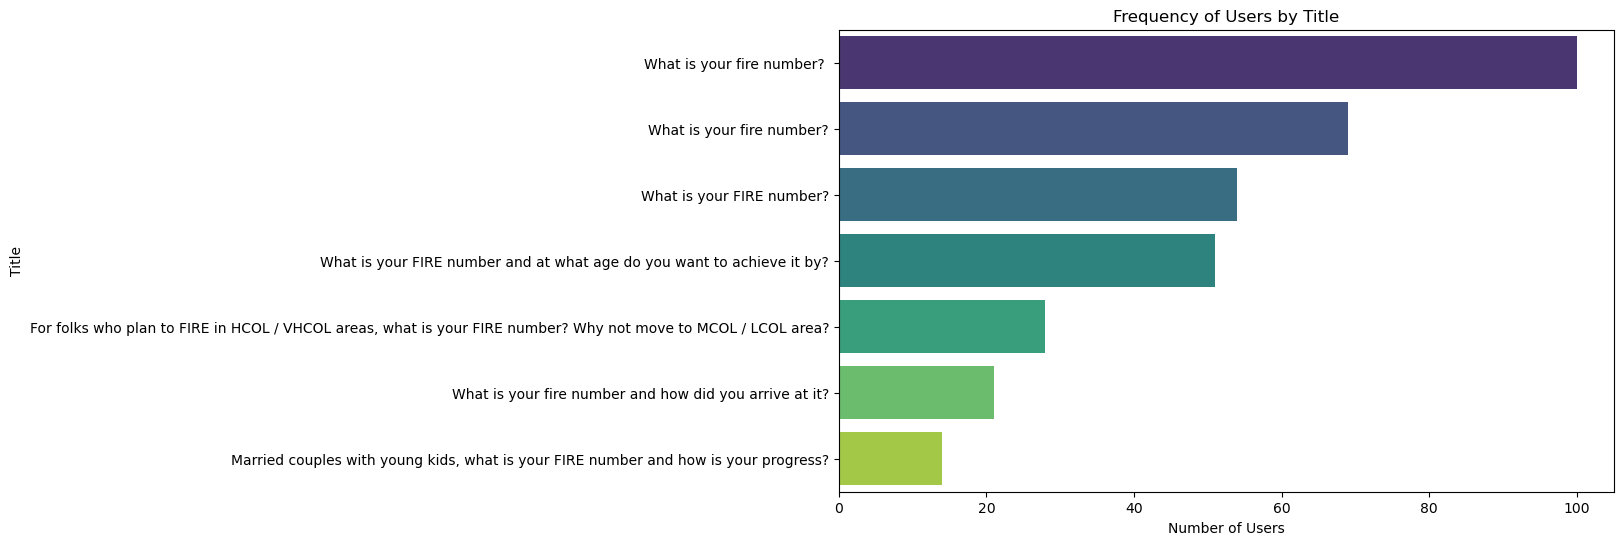

In [141]:
# The frequency of users by title
user_counts = fire_df_copy['Title'].value_counts().reset_index()
user_counts.columns = ['Title', 'Frequency']

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Title', data=user_counts, palette='viridis')
plt.title('Frequency of Users by Title')
plt.xlabel('Number of Users')
plt.ylabel('Title')
plt.show()

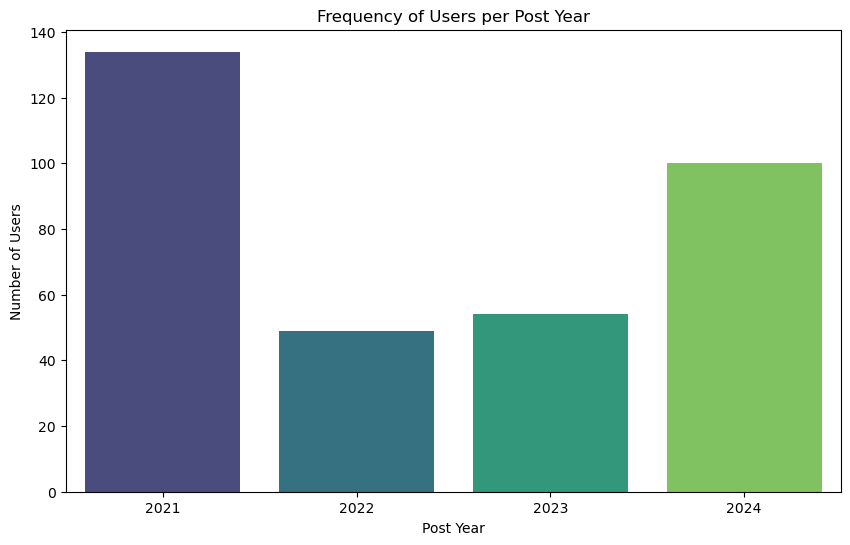

In [142]:
# Convert 'Post Time' to datetime
fire_df_copy['Post Time'] = pd.to_datetime(fire_df_copy['Post Time'])

# Extract the year from 'Post Time'
fire_df_copy['Post Year'] = fire_df_copy['Post Time'].dt.year

# Count the frequency of users per post year
user_counts = fire_df_copy.groupby('Post Year').size().reset_index(name='Frequency')

# Create the seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Post Year', y='Frequency', data=user_counts, palette='viridis')
plt.title('Frequency of Users per Post Year')
plt.xlabel('Post Year')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)  # No rotation needed for years
plt.show()

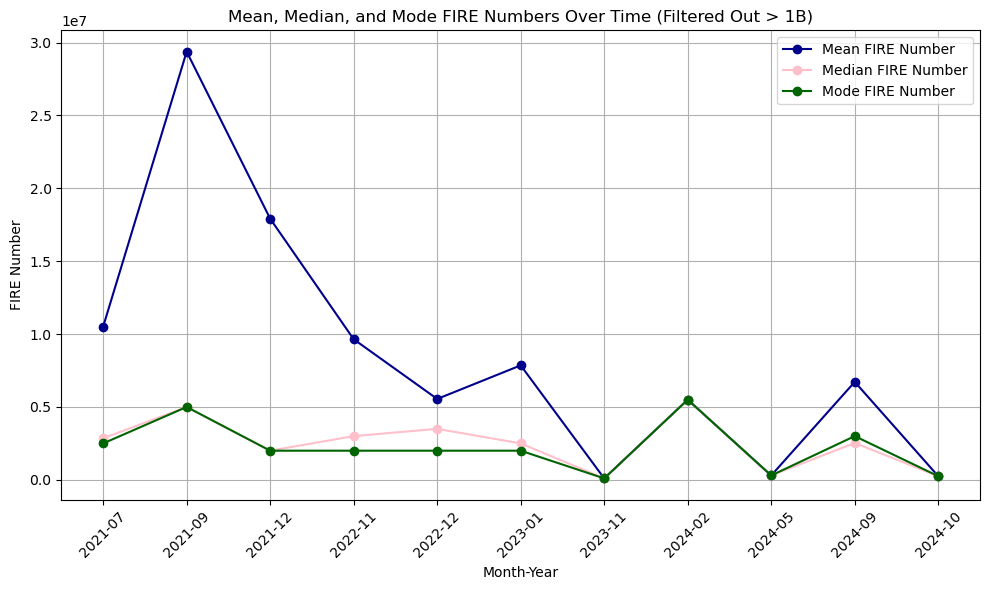

In [143]:
# Convert 'Comment Time' to datetime
fire_df_copy['Comment Time'] = pd.to_datetime(fire_df_copy['Comment Time'])

# Extract Month-Year and create a new column
fire_df_copy['Month-Year'] = fire_df_copy['Comment Time'].dt.to_period('M')

# Clean the 'FIRE Number' column by removing commas
fire_df_copy['FIRE Number'] = fire_df_copy['FIRE Number'].replace(',', '')

# Filter out FIRE numbers greater than 1 billion
fire_df_copy = fire_df_copy[fire_df_copy['FIRE Number'] <= 1_000_000_000]

# Group by Month-Year and calculate mean and median
monthly_stats = fire_df_copy.groupby('Month-Year')['FIRE Number'].agg(['mean', 'median'])

# Calculate mode separately since it can return multiple values
mode_series = fire_df_copy.groupby('Month-Year')['FIRE Number'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
monthly_stats['mode'] = mode_series

# Plotting the statistics
plt.figure(figsize=(10, 6))
plt.plot(monthly_stats.index.astype(str), monthly_stats['mean'], marker='o', label='Mean FIRE Number', color='darkblue')
plt.plot(monthly_stats.index.astype(str), monthly_stats['median'], marker='o', label='Median FIRE Number', color='pink')
plt.plot(monthly_stats.index.astype(str), monthly_stats['mode'], marker='o', label='Mode FIRE Number', color='darkgreen')

# Adding labels and title
plt.title('Mean, Median, and Mode FIRE Numbers Over Time (Filtered Out > 1B)')
plt.xlabel('Month-Year')
plt.ylabel('FIRE Number')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Model Development

## Topic Modeling

### Latent Dirichlet Allocation

In [144]:
lda = LatentDirichletAllocation(n_components=5, random_state=509)
lda.fit(X_ct)

LatentDirichletAllocation(n_components=5, random_state=509)

#### Examine topics from LDA at n=5 topics (arbritrary)

In [145]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")

        #For each topic, go through index i and retrieve word from that location
        #Topic is a vector of weights of each word for a given topic (higher = more important)
        #argsort() return indices of elements in topic in ascending importance
        #:-num_top_words - 1 = Start from last element -1 and move back num_top_words positions
        # --- This is to remove the lesser important words for interpretation purposes
        # -1 reverse order so it's descending now that noisy words are removed.
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [146]:
feature_names_lda = vectorizer_ct.get_feature_names_out()
num_top_words = 10
display_topics(lda, feature_names_lda, num_top_words)

Topic 0:
million thousand im number cash income living net expenses ill
Topic 1:
million thousand im year time 40 number travel work change
Topic 2:
im thousand million years paid house retirement family just number
Topic 3:
million live kids number life years like area want year
Topic 4:
million house paid thousand years im live number want ill


#### Result
Selecting n_components=5 might not be the correct number of topics to be able to clearly separate words into themes. Need to try another topic number.

### Retry LDA with n_components=8

In [147]:
lda = LatentDirichletAllocation(n_components=8, random_state=509)
lda.fit(X_ct)
feature_names_lda = vectorizer_ct.get_feature_names_out()
num_top_words = 10
display_topics(lda, feature_names_lda, num_top_words)

Topic 0:
million cash number thousand im expenses income living flow work
Topic 1:
million thousand travel live number year time like kids years
Topic 2:
im thousand million years house paid friends area family good
Topic 3:
million kids like want years number life right live city
Topic 4:
million thousand live want liquid years im area paid house
Topic 5:
retirement mortgage 333 5m 000 rate year accounts need rental
Topic 6:
million house paid years ill im 000 number 10 need
Topic 7:
million thousand im house number pension work mortgage probably years


This code below trains an LDA model and then saves both the model and the vectorizer to separate files so they can be reused without needing to retrain or refit.

In [148]:
# Fit the LDA model
lda = LatentDirichletAllocation(n_components=8, random_state=509)
lda.fit(X_ct)

# Save the model to a file
with open('lda_model.pkl', 'wb') as f:
    pickle.dump(lda, f)

# Save the vectorizer as well, if needed
with open('vectorizer_ct.pkl', 'wb') as f:
    pickle.dump(vectorizer_ct, f)

## DEPENDENCY.
Need to find a way to import a date of post or age of post so the model below can extract some sort of time or year for a time-series chart. Else, will have to select a different groupby.

### Sentiment Analysis with VaderSentiment

Reference

Hutto, C. J., Klein, E., Pantone, P., Berry, G., & Suresh, M. (2024, August 19). Documentation source code for nltk.sentiment.vader. https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [149]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/itzelcruz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [150]:
analyzer = SentimentIntensityAnalyzer() # Intialize the analyzer as object

In [151]:
def get_sentiment_score(comment):
    scores = analyzer.polarity_scores(comment)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']],
                    index=['Negative', 'Neutral', 'Positive', 'Compound'])

In [152]:
fire_df[['Negative', 'Neutral', 'Positive', 'Compound']] = fire_df['Cleaned Comment'].apply(get_sentiment_score)

In [153]:
fire_df[['Cleaned Comment', 'Negative', 'Neutral', 'Positive', 'Compound', 'FIRE Number']].head(10)

,Cleaned Comment,Negative,Neutral,Positive,Compound,FIRE Number
0,1.5 million with paid off houses,0.00,1.00,0.00,0.00,"1,500,000.00"
1,im just waiting for someone to say something l...,0.17,0.83,0.00,-0.40,"1,000,000.00"
2,$1.9m. targeting a few months after i turn 50 ...,0.07,0.93,0.00,-0.15,"1,900,000.00"
3,"on days i hate my job, 600k. the other days, d...",0.17,0.83,0.00,-0.57,"3,000,000.00"
4,2 million with a paid off house. so stressful ...,0.23,0.77,0.00,-0.64,"2,000,000.00"
5,our target back in 2014 was 1.2 million and a ...,0.06,0.87,0.07,-0.34,"1,400,000.00"
6,"500 thousand give or take, but i am not retiri...",0.00,1.00,0.00,0.00,"500,000.00"
7,"i started at 1.5 million 1015 years ago. now, ...",0.06,0.80,0.15,0.40,"3,000,000.00"
8,"re ship sailed, but still working on fi. house...",0.00,0.91,0.09,0.61,"4,000,000.00"
9,funny to read all these numbers while the medi...,0.00,0.66,0.34,0.77,"400,000.00"


### OPTIONAL:GROUPBY ANALYSIS, which requires additional JSON features to be pulled into CSV

In [154]:
fire_df.columns

Index(['Thread ID', 'Title', 'User', 'Comment', 'Post Time', 'Comment Time',
       'Cleaned Comment', 'FIRE Number', 'Post Year', 'Comment Year',
       'Capped FIRE Number', 'Negative', 'Neutral', 'Positive', 'Compound'],
      dtype='object')

In [155]:
sentiment_by_year = fire_df.groupby('Comment Year')[['Negative', 'Neutral', 'Positive', 'Compound']].mean()
sentiment_by_year_plus_fire = pd.merge(sentiment_by_year,
                                       fire_stats_by_comment_year,
                                       left_index=True,
                                       right_index=True)
sentiment_by_year_plus_fire

,Negative,Neutral,Positive,Compound,Mean FIRE,Median FIRE
Comment Year,,,,,,
2021,0.03,0.88,0.09,0.19,"4,089,085.21","2,850,000.00"
2022,0.05,0.84,0.11,0.32,"4,531,352.04","3,500,000.00"
2023,0.08,0.88,0.05,-0.02,"4,247,792.45","2,500,000.00"
2024,0.06,0.88,0.06,0.02,"3,835,507.33","2,850,000.00"


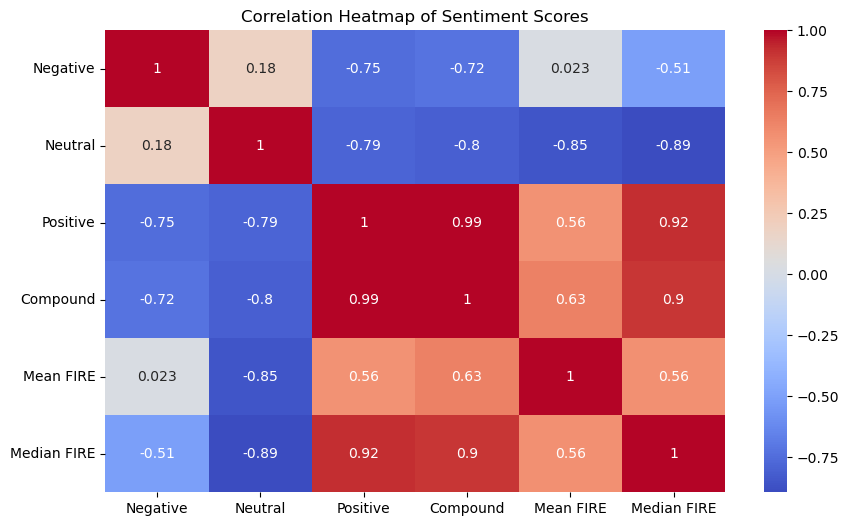

In [156]:
year_pearson = sentiment_by_year_plus_fire.corr(method='pearson')
plt.figure(figsize=(10, 6))
sns.heatmap(year_pearson, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Sentiment Scores')
plt.show()

#### Interpretation

Sentiment analysis appears to show that 2022 was especially positive using text comments whereas 2023 was the only net negative year. This tracks with the US inflation crisis that occured over this period. Interestingly, there is a strong negative correlation between mean and median FIRE number and positive sentiment. This may be due to optimism that the purchasing power of the currency in question is sufficient for retirement purposes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


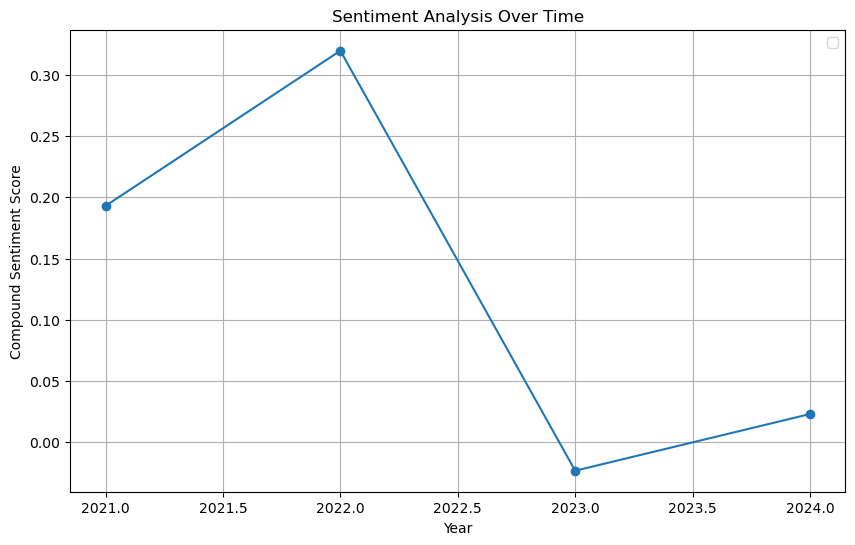

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_year.index, sentiment_by_year['Compound'], marker='o')
plt.title('Sentiment Analysis Over Time')
plt.xlabel('Year')
plt.ylabel('Compound Sentiment Score')
plt.grid(True)
plt.legend()
plt.show()

### Latent Semantic Analysis

In [158]:
n_topics = 5
lsa = TruncatedSVD(n_components=n_topics, random_state=509) # Initialize model
lsa_topic_matrix = lsa.fit_transform(X_tfidf) # Fit and transform for latent topics

In [159]:
feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()

In [160]:
display_topics(lsa, feature_names_tfidf, num_top_words) # Show top 10 words for each topic

Topic 0:
million house paid thousand years kids 10 im liquid live
Topic 1:
million 5055 40 33 school 2kids elementary 19 america middle
Topic 2:
house paid plus mcol 53 45 fat 4m 65 later
Topic 3:
thousand 500 600 month 800 liquid 20 retiring 300 million
Topic 4:
cash 50 college flow free work kids estate real actually


#### Show results
Row = score representing relevance of topic to the clean_comment

In [161]:
topics = pd.DataFrame(lsa_topic_matrix, columns=[f'Topic {i}' for i in range(n_topics)])
comb_topics = pd.concat([fire_df, topics], axis=1)
comb_topics[['Cleaned Comment', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4']].head(10)

,Cleaned Comment,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,1.5 million with paid off houses,0.28,-0.01,0.20,0.02,-0.01
1,im just waiting for someone to say something l...,0.03,-0.06,-0.07,-0.08,0.01
2,$1.9m. targeting a few months after i turn 50 ...,0.10,-0.14,0.03,-0.07,0.13
3,"on days i hate my job, 600k. the other days, d...",0.11,-0.01,-0.09,-0.04,-0.03
4,2 million with a paid off house. so stressful ...,0.60,-0.22,0.70,-0.01,0.05
5,our target back in 2014 was 1.2 million and a ...,0.22,-0.10,0.09,-0.08,-0.02
6,"500 thousand give or take, but i am not retiri...",0.06,-0.20,-0.11,0.52,0.05
7,"i started at 1.5 million 1015 years ago. now, ...",0.25,0.02,-0.07,-0.04,0.05
8,"re ship sailed, but still working on fi. house...",0.17,-0.19,0.03,-0.04,0.08
9,funny to read all these numbers while the medi...,0.03,-0.07,-0.06,-0.03,0.02


# Build Flask Application

## Set-up Flask


Import Packages

In [ ]:
# Import packages
#!pip install Flask
#!pip install pyngrok

Upload Libraries

## Simple Flask Application

Since the numbers of features between my vectorizer and LDA model did not match, had to retrain the LDA model.

In [162]:
import os
import subprocess
print(os.path.getsize('lda_model.pkl'))  # should return a non-zero value

239724


In [163]:
X_ct = vectorizer_ct.fit_transform(fire_df['Cleaned Comment'])

In [164]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=509)
lda_model.fit(X_ct)


LatentDirichletAllocation(n_components=5, random_state=509)

In [165]:
# Check the number of features (components) in the LDA model
print(f"Number of features expected by the LDA model: {lda_model.components_.shape[1]}")

Number of features expected by the LDA model: 1845


In [166]:
# Save the new LDA model
with open('new_lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)

# Save the current vectorizer
with open('new_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer_ct, f)

In [1]:
# Initialize Flask app
app = Flask(__name__)

# Function to find a free port (Optional, but useful for deployment conflicts)
def find_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(('', 0))
    port = s.getsockname()[1]
    s.close()
    return port

# Start ngrok using authentication for security purposes
# https://ngrok.com/blog-post/authentication-with-ngrok
def start_ngrok(port):
    username = "torero24"
    password = "ads509_FIRE"
    ngrok_cmd = ["ngrok", "http", f"{port}", f"--basic-auth={username}:{password}"]
    ngrok_process = subprocess.Popen(ngrok_cmd)
    time.sleep(3)
    return ngrok_process

# Load pre-trained LDA model and TF-IDF vectorizer
lda_model_path = 'new_lda_model.pkl'
vectorizer_path = 'new_vectorizer.pkl'
fire_df_path = 'fire_comments.csv'

# Load LDA model, vectorizer, and data
with open(lda_model_path, 'rb') as f:
    lda_model = pickle.load(f)

with open(vectorizer_path, 'rb') as f:
    vectorizer = pickle.load(f)

fire_df = pd.read_csv(fire_df_path)

# Load Sentiment Analyzer (Vader)
analyzer = SentimentIntensityAnalyzer()

# Route for home and classification and sentiment analysis
@app.route('/', methods=['GET', 'POST'])
def classify_and_analyze():
    if request.method == 'POST':
        input_text = request.form['text']  # Get text from form submission

        # Perform topic classification
        input_vectorized = vectorizer.transform([input_text])
        topics_distribution = lda_model.transform(input_vectorized)
        predicted_topic = topics_distribution.argmax()

        # Perform sentiment analysis
        sentiment_scores = analyzer.polarity_scores(input_text)

        # Send results as JSON and display them on the index page
        return render_template(
            'index.html',
            input_text=input_text,
            predicted_topic=predicted_topic,
            sentiment_scores=sentiment_scores
        )
    return render_template('index.html')

# Route for topic overview with visualizations
import matplotlib.cm as cm

@app.route('/overview')
def overview():
    topic_keywords = {}
    num_top_words = 10
    feature_names = vectorizer.get_feature_names_out()

    #list of colors for the topics
    colors = ['steelblue', 'seagreen', 'orange', 'purple', 'crimson', 'darkcyan', 'gold', 'teal', 'coral', 'navy']
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topic_keywords[f'Topic {topic_idx}'] = top_words

        # Select a color for the current topic (repeats if there are more topics than colors)
        color = colors[topic_idx % len(colors)]
        
        # Create a bar plot for each topic
        plt.figure(figsize=(8, 5))
        plt.barh(top_words, topic[topic.argsort()[:-num_top_words - 1:-1]], color=color)
        plt.xlabel("Word Importance", fontsize=12)
        plt.title(f"Top {num_top_words} Words for Topic {topic_idx}", fontsize=14)
        plt.tight_layout()

        # Save the plot to a BytesIO object
        img = io.BytesIO()
        plt.savefig(img, format='png', bbox_inches="tight")
        img.seek(0)
        img_b64 = base64.b64encode(img.getvalue()).decode()

        # Add the plot to the topic_keywords dictionary as a base64 image
        topic_keywords[f'Topic {topic_idx}_plot'] = img_b64

    return render_template('overview.html', topics=topic_keywords)

if __name__ == '__main__':
    port = find_free_port()  # Find a free port to avoid conflicts
    ngrok_process = start_ngrok(port) # Start with basic authentication
    try:
        app.run(debug=True, use_reloader=False, port=port) # Start app
    except KeyboardInterrupt: # With Ctrl+C or other equivalent
        print("Shutting down ngrok connection")
        ngrok_process.terminate()
    print(f"Port {port} is free and tunnel is closed.")


NameError: name 'Flask' is not defined

Left the first one I created if needed. Will delete once we have flask completed. 

In [213]:
# Start Flask app
##app = Flask(__name__)

##def find_free_port():
    ##s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    ##s.bind(('', 0))
    ##port = s.getsockname()[1]
    ##s.close()
    ##return port

# Load pre-trained LDA model and TF-IDF vectorizer
##lda_model_path = 'new_lda_model.pkl'
##vectorizer_path = 'new_vectorizer.pkl'
##fire_df_path = 'fire_comments.csv'

# Load LDA model, vectorizer, and data
##with open(lda_model_path, 'rb') as f:
    ##lda_model = pickle.load(f)

##with open(vectorizer_path, 'rb') as f:
    ##vectorizer = pickle.load(f)

##fire_df = pd.read_csv(fire_df_path)

# Load Sentiment Analyzer (Vader)
##analyzer = SentimentIntensityAnalyzer()

# Home route for text classification and sentiment analysis
##@app.route('/')
##def home():
    ##return render_template('index.html')

# Perform classification and sentiment analysis
##@app.route('/classify', methods=['POST'])
##def classify():
    ##input_text = request.form['text']  # Get text from form submission

    # Vectorize input text
    ##input_vectorized = vectorizer.transform([input_text])

    # Predict topic with LDA model
    ##topics_distribution = lda_model.transform(input_vectorized)
    ##predicted_topic = topics_distribution.argmax()

    # Perform sentiment analysis with Vader
    ##sentiment_scores = analyzer.polarity_scores(input_text)

    # Send results as JSON and display them on the index page
    ##return render_template(
        ##'index.html',
        ##input_text=input_text,
        ##predicted_topic=predicted_topic,
        ##sentiment_scores=sentiment_scores
    ##)

# Overview route for topic modeling

##import plotly.graph_objs as go
##import json

##@app.route('/overview')
##def overview():
    ##topic_keywords = {}
    ##num_top_words = 10
    ##feature_names = vectorizer.get_feature_names_out()

    ##for topic_idx, topic in enumerate(lda_model.components_):
        ##top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        ##topic_keywords[f'Topic {topic_idx}'] = top_words

        # Create a bar plot for each topic
        ##plt.figure(figsize=(10, 5))
        ##plt.barh(top_words, topic[topic.argsort()[:-num_top_words - 1:-1]])
        ##plt.xlabel("Word Importance")
        ##plt.title(f"Top {num_top_words} Words for Topic {topic_idx}")

        # Save the plot to a BytesIO object
        ##img = io.BytesIO()
        ##plt.savefig(img, format='png')
        ##img.seek(0)
        ##img_b64 = base64.b64encode(img.getvalue()).decode()

        # Add the plot to the topic_keywords dictionary as a base64 image
        ##topic_keywords[f'Topic {topic_idx}_plot'] = img_b64

    ##return render_template('overview.html', topics=topic_keywords)

##if __name__ == '__main__':
    ##port = find_free_port()  # Find a free port to avoid conflicts
    ##app.run(debug=True, use_reloader=False, port=port)


In [ ]:
# Set up ngrok authtoken
##!ngrok authtoken 2mxORvZevUlWiZcP42H0kKWt5Db_62uzFBWQsdosv7Eau5TWZ

# Create Flask app
##app = Flask(__name__)

##@app.route('/')
##def home():
    ##return "Welcome to the FIRE Number Analyzer!"

##@app.route('/analyze', methods=['POST'])
##def analyze():
    ##data = request.json
    # Placeholder for analysis logic
    ##return jsonify({"message": "Analysis complete!"})

# Function to run the Flask app
##def run_app():
    ##app.run(port=5000)

# Start Flask app in a new thread
##threading.Thread(target=run_app).start()

# Set up a tunnel to the Flask app
##public_url = ngrok.connect(5000)
##print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:5000\"".format(public_url))

NameError: name 'ngrok' is not defined

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
